In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from algos import *
from infect import *
from sbm import *

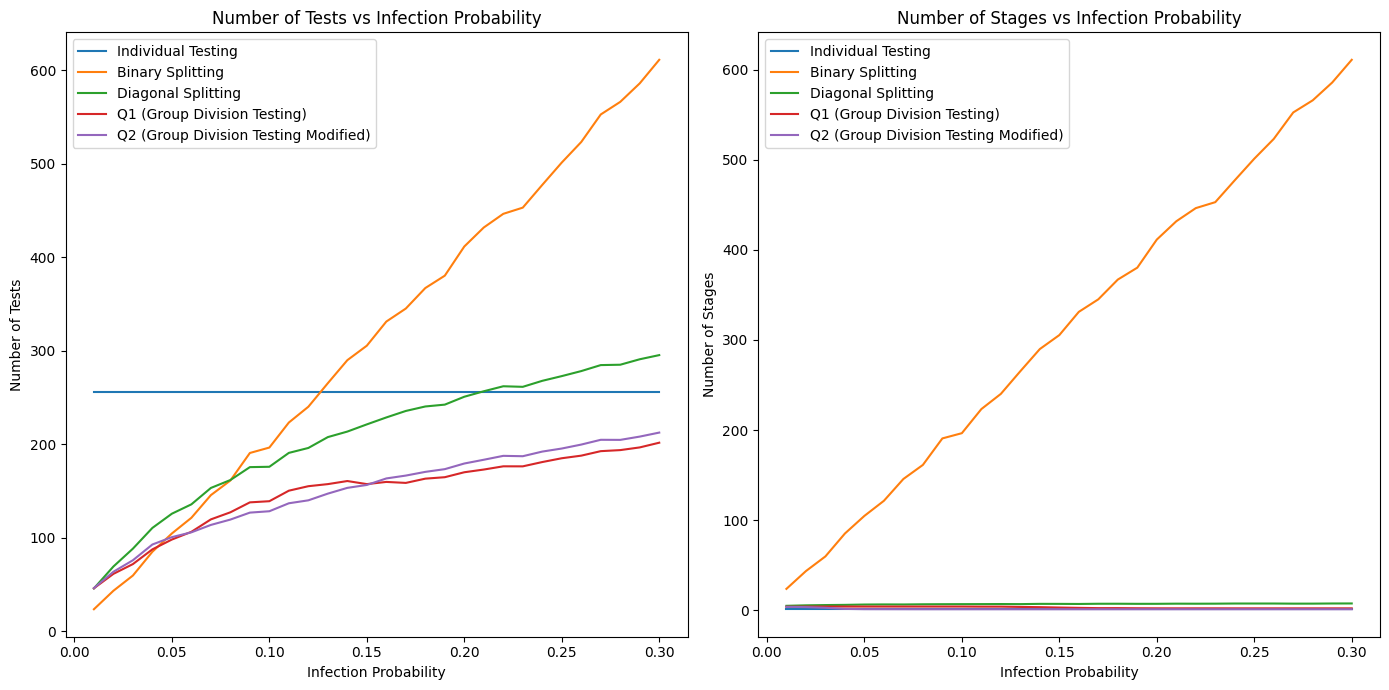

In [2]:
# Number of simulations to average over
num_simulations = 100
# np.random.seed(55)

# Initialize lists to store results
infection_probs = np.arange(0.01, 0.31, 0.01)
individual_tests_list = []
binary_tests_list = []
parallel_binary_tests_list = []
diag_tests_list = []
Q1_tests_list = []
group_division_tests_list = []

individual_stages_list = []
binary_stages_list = []
parallel_binary_stages_list = []
diag_stages_list = []
Q1_stages_list = []
group_division_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    individual_tests_avg, binary_tests_avg, parallel_binary_tests_avg = 0, 0, 0
    diag_tests_avg, Q1_tests_avg, group_division_tests_avg = 0, 0, 0
    individual_stages_avg, binary_stages_avg, parallel_binary_stages_avg = 0, 0, 0
    diag_stages_avg, Q1_stages_avg, group_division_stages_avg = 0, 0, 0
    
    for _ in range(num_simulations):  # Average over num_simulations tests
        array = np.random.choice([0, 1], size=256, p=[1 - p, p])

        individual_tests, individual_stages = individual_testing(array)
        binary_tests, binary_stages = binary_splitting(array)[0:2]
        parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
        diag_tests, diag_stages = diag_splitting(array)
        Q1_tests, Q1_stages = Qtesting1(array)
        group_division_tests, group_division_stages = Qtesting2(array)

        individual_tests_avg += individual_tests
        binary_tests_avg += binary_tests
        parallel_binary_tests_avg += parallel_binary_tests
        diag_tests_avg += diag_tests
        Q1_tests_avg += Q1_tests
        group_division_tests_avg += group_division_tests

        individual_stages_avg += individual_stages
        binary_stages_avg += binary_stages
        parallel_binary_stages_avg += parallel_binary_stages
        diag_stages_avg += diag_stages
        Q1_stages_avg += Q1_stages
        group_division_stages_avg += group_division_stages

    individual_tests_list.append(individual_tests_avg / num_simulations)
    binary_tests_list.append(binary_tests_avg / num_simulations)
    parallel_binary_tests_list.append(parallel_binary_tests_avg / num_simulations)
    diag_tests_list.append(diag_tests_avg / num_simulations)
    Q1_tests_list.append(Q1_tests_avg / num_simulations)
    group_division_tests_list.append(group_division_tests_avg / num_simulations)

    individual_stages_list.append(individual_stages_avg / num_simulations)
    binary_stages_list.append(binary_stages_avg / num_simulations)
    parallel_binary_stages_list.append(parallel_binary_stages_avg / num_simulations)
    diag_stages_list.append(diag_stages_avg / num_simulations)
    Q1_stages_list.append(Q1_stages_avg / num_simulations)
    group_division_stages_list.append(group_division_stages_avg / num_simulations)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, individual_tests_list, label='Individual Testing')
plt.plot(infection_probs, binary_tests_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_tests_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_tests_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_tests_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, group_division_tests_list, label='Q2 (Group Division Testing Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, individual_stages_list, label='Individual Testing')
plt.plot(infection_probs, binary_stages_list, label='Binary Splitting')
# plt.plot(infection_probs, parallel_binary_stages_list, label='Parallel Binary Splitting')
plt.plot(infection_probs, diag_stages_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_stages_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, group_division_stages_list, label='Q2 (Group Division Testing Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()


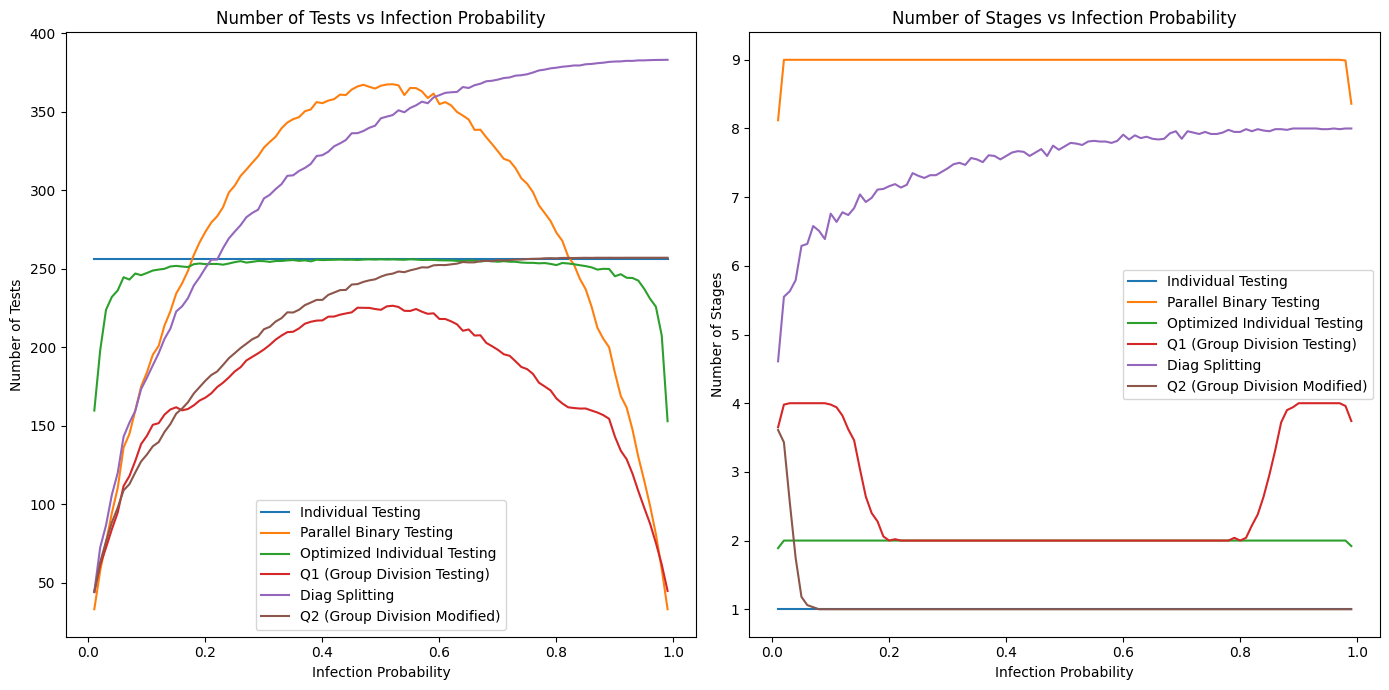

In [93]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of simulations to average over
num_simulations = 100

# Initialize lists to store results
infection_probs = np.arange(0.01, 1, 0.01)
individual_tests_list = []
parallel_binary_tests_list = []
optimized_individual_tests_list = []
group_division_tests_list = []
diag_splitting_tests_list = []
q2_group_division_tests_list = []

individual_stages_list = []
parallel_binary_stages_list = []
optimized_individual_stages_list = []
group_division_stages_list = []
diag_splitting_stages_list = []
q2_group_division_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    individual_tests_avg = 0
    parallel_binary_tests_avg = 0
    optimized_individual_tests_avg = 0
    group_division_tests_avg = 0
    diag_splitting_tests_avg = 0
    q2_group_division_tests_avg = 0
    
    individual_stages_avg = 0
    parallel_binary_stages_avg = 0
    optimized_individual_stages_avg = 0
    group_division_stages_avg = 0
    diag_splitting_stages_avg = 0
    q2_group_division_stages_avg = 0
    
    for _ in range(num_simulations):  # Average over num_simulations tests
        array = np.random.choice([0, 1], size=256, p=[1 - p, p])

        individual_tests, individual_stages = individual_testing(array)
        parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
        optimized_individual_tests, optimized_individual_stages = optimized_individual_testing(array)
        group_division_tests, group_division_stages = group_division_testing(array)
        diag_splitting_tests, diag_splitting_stages = diag_splitting(array)
        q2_group_division_tests, q2_group_division_stages = group_division_testing_T2(array)

        individual_tests_avg += individual_tests
        parallel_binary_tests_avg += parallel_binary_tests
        optimized_individual_tests_avg += optimized_individual_tests
        group_division_tests_avg += group_division_tests
        diag_splitting_tests_avg += diag_splitting_tests
        q2_group_division_tests_avg += q2_group_division_tests

        individual_stages_avg += individual_stages
        parallel_binary_stages_avg += parallel_binary_stages
        optimized_individual_stages_avg += optimized_individual_stages
        group_division_stages_avg += group_division_stages
        diag_splitting_stages_avg += diag_splitting_stages
        q2_group_division_stages_avg += q2_group_division_stages

    individual_tests_list.append(individual_tests_avg / num_simulations)
    parallel_binary_tests_list.append(parallel_binary_tests_avg / num_simulations)
    optimized_individual_tests_list.append(optimized_individual_tests_avg / num_simulations)
    group_division_tests_list.append(group_division_tests_avg / num_simulations)
    diag_splitting_tests_list.append(diag_splitting_tests_avg / num_simulations)
    q2_group_division_tests_list.append(q2_group_division_tests_avg / num_simulations)

    individual_stages_list.append(individual_stages_avg / num_simulations)
    parallel_binary_stages_list.append(parallel_binary_stages_avg / num_simulations)
    optimized_individual_stages_list.append(optimized_individual_stages_avg / num_simulations)
    group_division_stages_list.append(group_division_stages_avg / num_simulations)
    diag_splitting_stages_list.append(diag_splitting_stages_avg / num_simulations)
    q2_group_division_stages_list.append(q2_group_division_stages_avg / num_simulations)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, individual_tests_list, label='Individual Testing')
plt.plot(infection_probs, parallel_binary_tests_list, label='Parallel Binary Testing')
plt.plot(infection_probs, optimized_individual_tests_list, label='Optimized Individual Testing')
plt.plot(infection_probs, group_division_tests_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, diag_splitting_tests_list, label='Diag Splitting')
plt.plot(infection_probs, q2_group_division_tests_list, label='Q2 (Group Division Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, individual_stages_list, label='Individual Testing')
plt.plot(infection_probs, parallel_binary_stages_list, label='Parallel Binary Testing')
plt.plot(infection_probs, optimized_individual_stages_list, label='Optimized Individual Testing')
plt.plot(infection_probs, group_division_stages_list, label='Q1 (Group Division Testing)')
plt.plot(infection_probs, diag_splitting_stages_list, label='Diag Splitting')
plt.plot(infection_probs, q2_group_division_stages_list, label='Q2 (Group Division Modified)')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Function Tests

infection_probability = 0.1
iterations = 100

# Initialize arrays to store results
individual_tests_results = []
individual_stages_results = []
opt_individual_tests_results = []
opt_individual_stages_results = []
parallel_binary_tests_results = []
parallel_binary_stages_results = []
diag_tests_results = []
diag_stages_results = []
Q1_tests_results = []
Q1_stages_results = []
Q1_bin_tests_results = []
Q1_bin_stages_results = []

for _ in range(iterations):
    array = np.random.choice([0, 1], size=256, p=[1 - infection_probability, infection_probability])
    
    individual_tests, individual_stages = individual_testing(array)
    individual_tests_results.append(individual_tests)
    individual_stages_results.append(individual_stages)
    
    opt_individual_tests, opt_individual_stages = optimized_individual_testing(array)
    opt_individual_tests_results.append(opt_individual_tests)
    opt_individual_stages_results.append(opt_individual_stages)
    
    parallel_binary_tests, parallel_binary_stages = parallel_binary_splitting(array)
    parallel_binary_tests_results.append(parallel_binary_tests)
    parallel_binary_stages_results.append(parallel_binary_stages)
    
    diag_tests, diag_stages = diag_splitting(array)
    diag_tests_results.append(diag_tests)
    diag_stages_results.append(diag_stages)
    
    Q1_tests, Q1_stages = Qtesting1(array)
    Q1_tests_results.append(Q1_tests)
    Q1_stages_results.append(Q1_stages)
    
    Q1_bin_tests, Q1_bin_stages = Qtesting1_bin(array)
    Q1_bin_tests_results.append(Q1_bin_tests)
    Q1_bin_stages_results.append(Q1_bin_stages)

# Calculate averages
avg_individual_tests = np.mean(individual_tests_results)
avg_individual_stages = np.mean(individual_stages_results)
avg_opt_individual_tests = np.mean(opt_individual_tests_results)
avg_opt_individual_stages = np.mean(opt_individual_stages_results)
avg_parallel_binary_tests = np.mean(parallel_binary_tests_results)
avg_parallel_binary_stages = np.mean(parallel_binary_stages_results)
avg_diag_tests = np.mean(diag_tests_results)
avg_diag_stages = np.mean(diag_stages_results)
avg_Q1_tests = np.mean(Q1_tests_results)
avg_Q1_stages = np.mean(Q1_stages_results)
avg_Q1_bin_tests = np.mean(Q1_bin_tests_results)
avg_Q1_bin_stages = np.mean(Q1_bin_stages_results)

# Print results
print(f"Average results for infection probability = {infection_probability} over {iterations} iterations:")
print(f"Naive: {avg_individual_tests:.2f} tests, {avg_individual_stages:.2f} stages")
print(f"Optimized Naive: {avg_opt_individual_tests:.2f} tests, {avg_opt_individual_stages:.2f} stages")
print(f"Parallel Binary: {avg_parallel_binary_tests:.2f} tests, {avg_parallel_binary_stages:.2f} stages")
print(f"Diag: {avg_diag_tests:.2f} tests, {avg_diag_stages:.2f} stages")
print(f"Q1: {avg_Q1_tests:.2f} tests, {avg_Q1_stages:.2f} stages")
print(f"Q1 Bin: {avg_Q1_bin_tests:.2f} tests, {avg_Q1_bin_stages:.2f} stages")

Average results for infection probability = 0.1 over 100 iterations:
Naive: 256.00 tests, 1.00 stages
Optimized Naive: 246.26 tests, 2.00 stages
Parallel Binary: 183.56 tests, 9.00 stages
Diag: 180.67 tests, 6.62 stages
Q1: 144.04 tests, 4.00 stages
Q1 Bin: 183.56 tests, 9.00 stages


In [14]:
def create_communities(N, M):
    """
    Function to create communities with approximately equal number of nodes.

    Parameters:
    N (int): Total number of nodes.
    M (int): Number of communities.

    Returns:
    List[List[int]]: 2D array of indices for each community.
    """
    communities = []
    nodes_per_community = N // M
    extra_nodes = N % M

    start = 0
    for i in range(M):
        end = start + nodes_per_community + (1 if i < extra_nodes else 0)
        communities.append(list(range(start, end)))
        start = end

    return communities

In [129]:
N = 1024
M = 128
q0 = 1
q1 = 0
p0 = 0.001
p1 = 0.5
time_steps = 2

num_simulations = 25
total_comm_aware_tests = 0
total_comm_aware_stages = 0
total_group_div_tests = 0
total_group_div_stages = 0

for i in range(num_simulations):
  G = SBM(N, M, q0, q1)
  final_state = infect(G, p0, p1, time_steps)

  # print("Total infected:", sum(final_state))
  # print("Percent infected:", sum(final_state)/len(final_state))
  # print_subarrays(final_state, N, M)

  communities = create_communities(N,M)

  comm_aware_tests, comm_aware_stages = Qtesting1_comm_aware(final_state, communities)
  total_comm_aware_tests += comm_aware_tests
  total_comm_aware_stages += comm_aware_stages
  # print("Num Tests Comm", comm_aware_tests)
  # print("Num Stages Comm", comm_aware_stages)

  np.random.shuffle(final_state)
  group_div_tests, group_div_stages = group_division_testing(final_state)
  total_group_div_tests += group_div_tests
  total_group_div_stages += group_div_stages
  # print("Num Tests GD", group_div_tests)
  # print("Num Stages GD", group_div_stages)


print("Average Num Tests Comm Aware", total_comm_aware_tests/num_simulations)
print("Average Num Stages Comm Aware", total_comm_aware_stages/num_simulations)
print("Average Num Tests GD", total_group_div_tests/num_simulations)
print("Average Num Stages GD", total_group_div_stages/num_simulations)


Average Num Tests Comm Aware 22.84
Average Num Stages Comm Aware 3.48
Average Num Tests GD 110.12
Average Num Stages GD 4.2


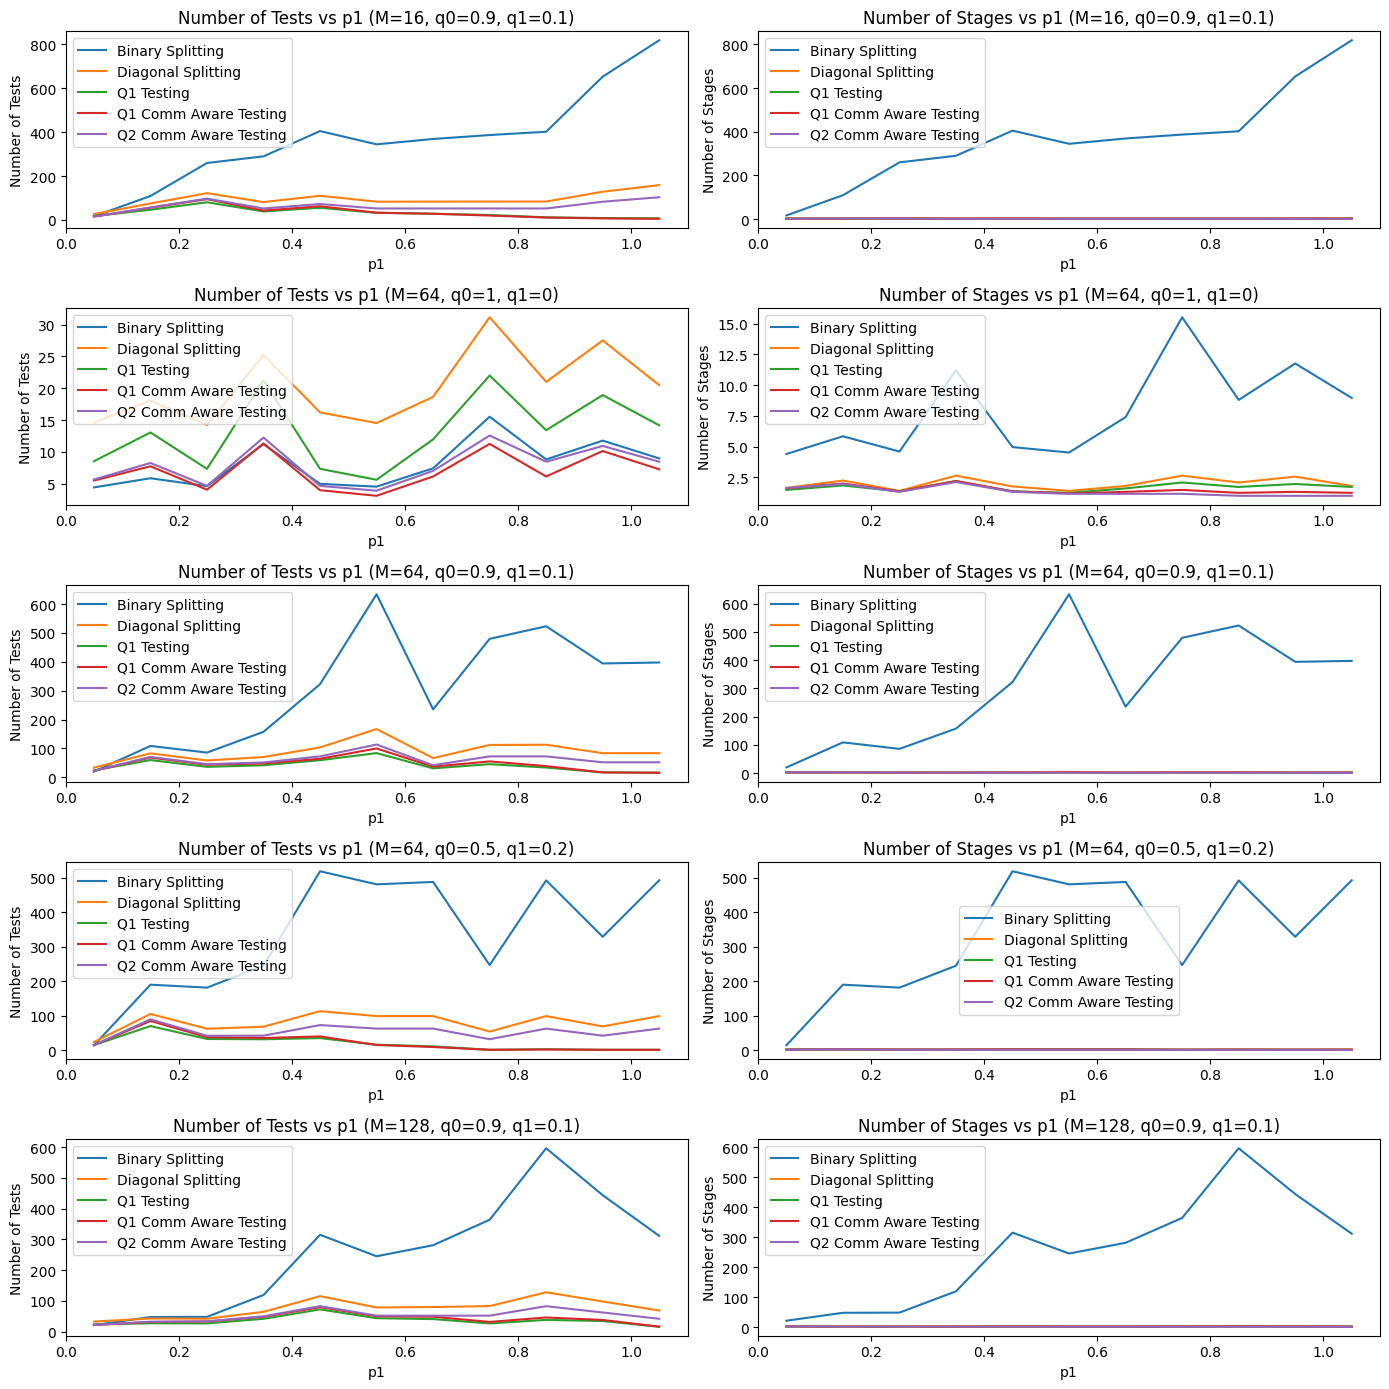

In [101]:


# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"individual": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 100
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        individual_tests_total, individual_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
        Q2Comm_tests_total, Q2Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            final_state = infect(G, p0, p1, time_steps)

            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
            Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
            np.random.shuffle(final_state)
            individual_tests, individual_stages = individual_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            
            individual_tests_total += individual_tests
            individual_stages_total += individual_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages
            Q2Comm_tests_total += Q2Comm_tests
            Q2Comm_stages_total += Q2Comm_stages

        results[(M, q0, q1, p0, time_steps)]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()



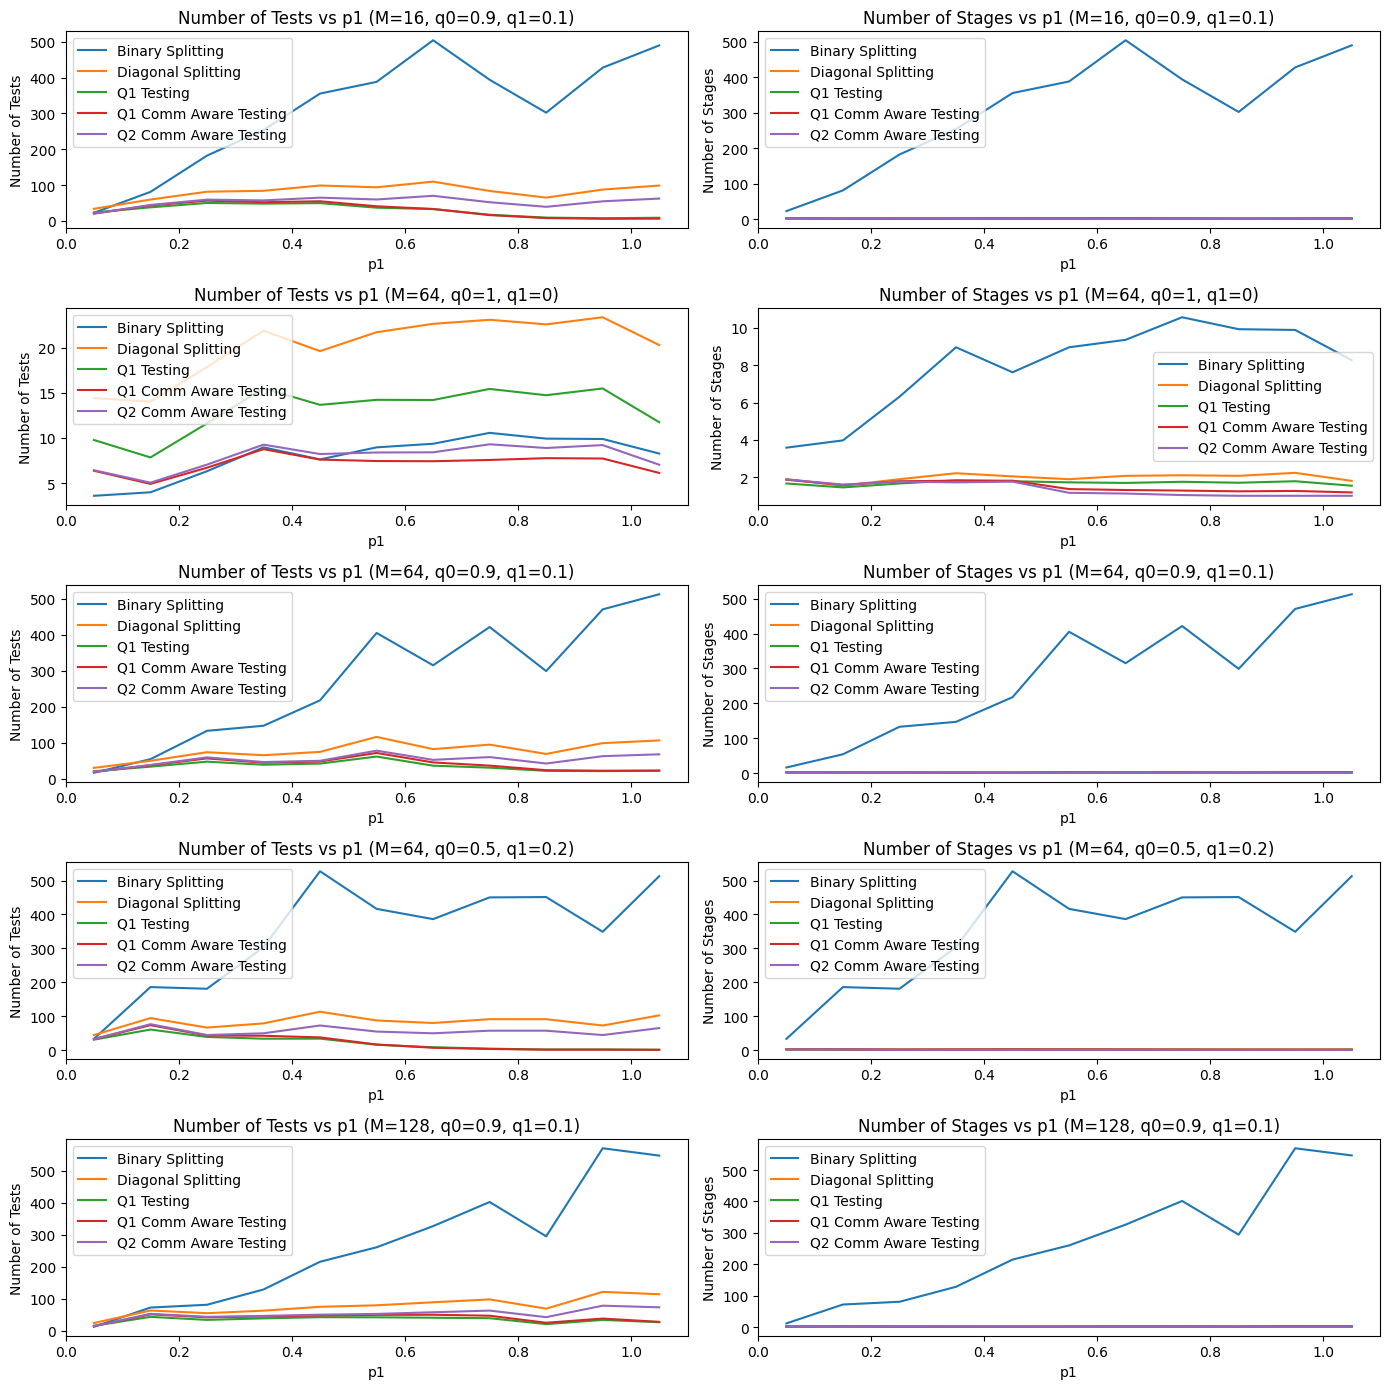

In [102]:
# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"individual": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 100
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        individual_tests_total, individual_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
        Q2Comm_tests_total, Q2Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            final_state = infect(G, p0, p1, time_steps)

            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
            Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
            np.random.shuffle(final_state)
            individual_tests, individual_stages = individual_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            
            individual_tests_total += individual_tests
            individual_stages_total += individual_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages
            Q2Comm_tests_total += Q2Comm_tests
            Q2Comm_stages_total += Q2Comm_stages

        results[(M, q0, q1, p0, time_steps)]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"individual": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 25
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        individual_tests_total, individual_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
        Q2Comm_tests_total, Q2Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            final_state = infect(G, p0, p1, time_steps)

            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
            Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
            np.random.shuffle(final_state)
            individual_tests, individual_stages = individual_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            
            individual_tests_total += individual_tests
            individual_stages_total += individual_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages
            Q2Comm_tests_total += Q2Comm_tests
            Q2Comm_stages_total += Q2Comm_stages

        results[(M, q0, q1, p0, time_steps)]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q2Comm"]], label='Q2 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()

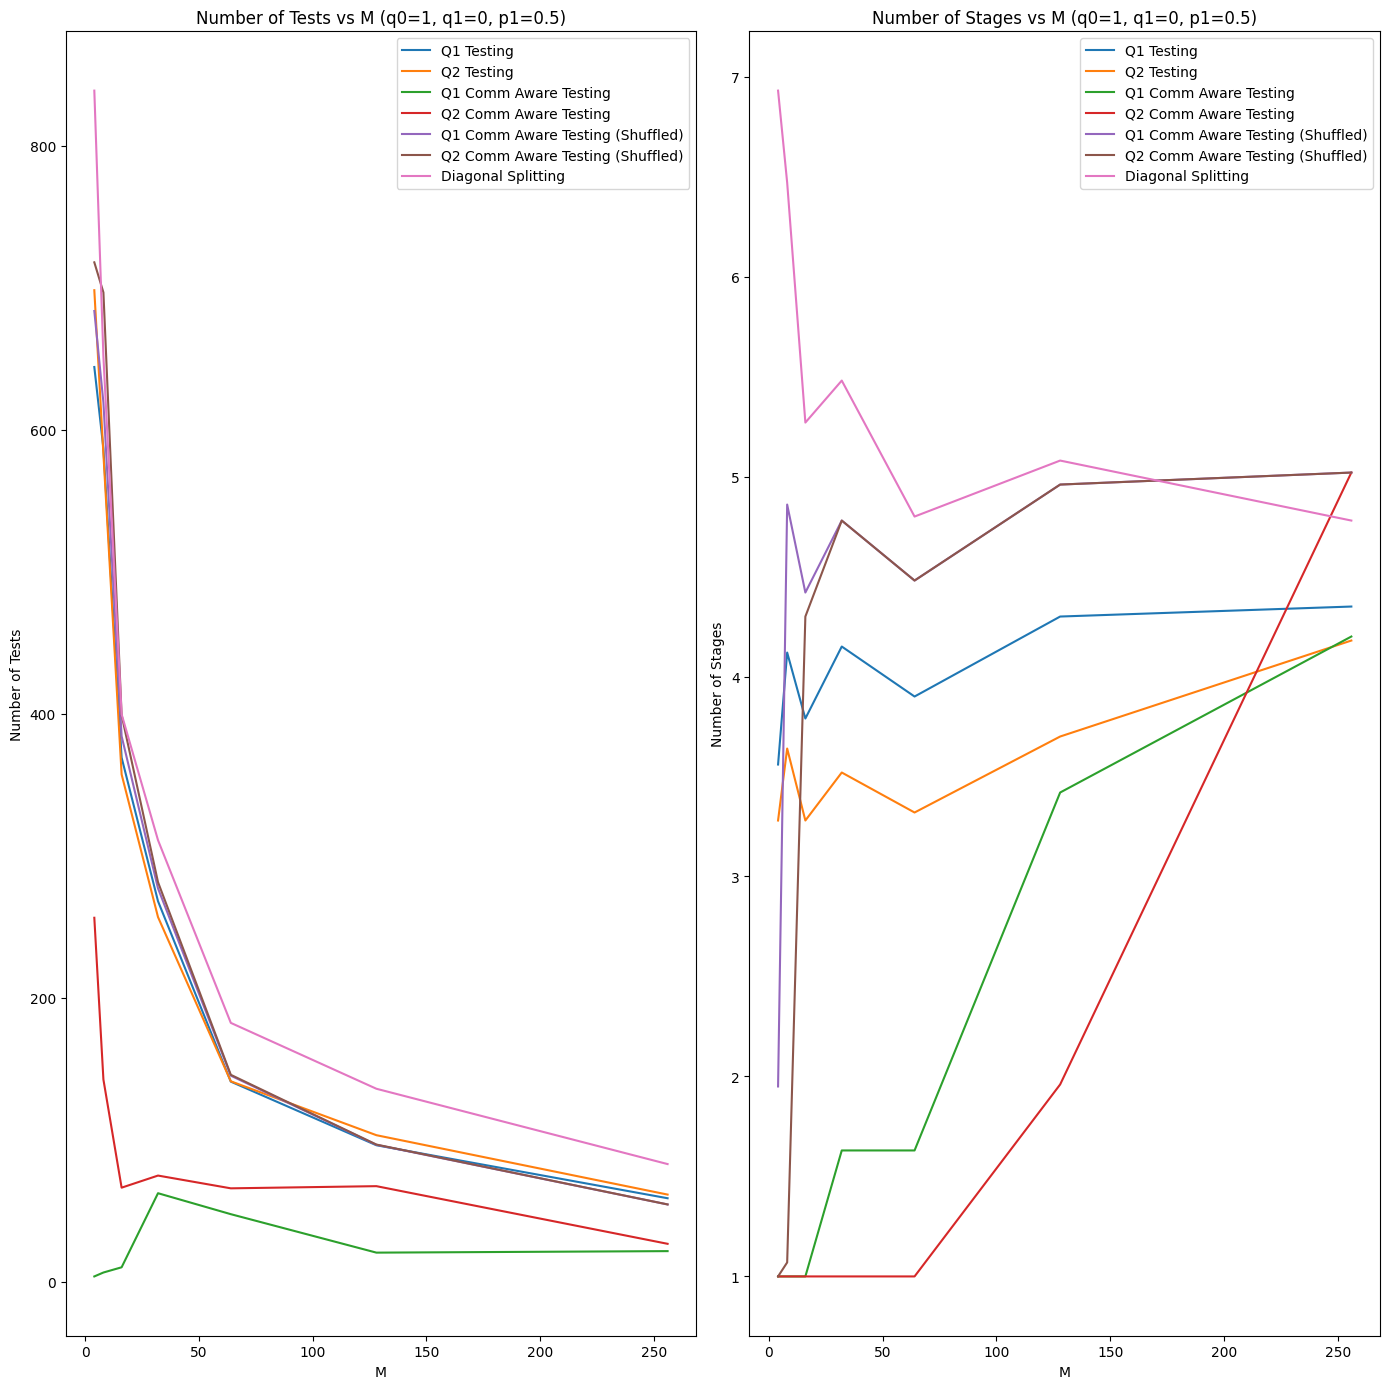

In [126]:
# PLOT M

# Set parameters
N = 1024
p0 = 0.001
p1 = 0.5
q0 = 1
q1 = 0
M_values = [4, 8, 16, 32, 64, 128, 256]

# Initialize lists to store results
results = {M: {"individual": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2": [], "Q2Comm": [],
               "Q1CommShuffled": [], "Q2CommShuffled": [], "diag": []} for M in M_values}

# Run simulations
num_simulations = 100
for M in M_values:
    individual_tests_total, individual_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q2_tests_total, Q2_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
    Q2Comm_tests_total, Q2Comm_stages_total = 0, 0
    Q1CommShuffled_tests_total, Q1CommShuffled_stages_total = 0, 0
    Q2CommShuffled_tests_total, Q2CommShuffled_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        final_state = infect(G, p0, p1, 2)

        # Tests before shuffling
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
        Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
        
        # Shuffle and test again
        np.random.shuffle(final_state)
        individual_tests, individual_stages = individual_testing(final_state)
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q2_tests, Q2_stages = Qtesting2(final_state)
        Q1CommShuffled_tests, Q1CommShuffled_stages = Qtesting1_comm_aware(final_state, communities)
        Q2CommShuffled_tests, Q2CommShuffled_stages = Qtesting2_comm_aware(final_state, communities)

        individual_tests_total += individual_tests
        individual_stages_total += individual_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q2_tests_total += Q2_tests
        Q2_stages_total += Q2_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages
        Q2Comm_tests_total += Q2Comm_tests
        Q2Comm_stages_total += Q2Comm_stages
        Q1CommShuffled_tests_total += Q1CommShuffled_tests
        Q1CommShuffled_stages_total += Q1CommShuffled_stages
        Q2CommShuffled_tests_total += Q2CommShuffled_tests
        Q2CommShuffled_stages_total += Q2CommShuffled_stages


    results[M]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
    results[M]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
    results[M]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results[M]["Q2"].append((Q2_tests_total / num_simulations, Q2_stages_total / num_simulations))
    results[M]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
    results[M]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))
    results[M]["Q1CommShuffled"].append((Q1CommShuffled_tests_total / num_simulations, Q1CommShuffled_stages_total / num_simulations))
    results[M]["Q2CommShuffled"].append((Q2CommShuffled_tests_total / num_simulations, Q2CommShuffled_stages_total / num_simulations))
    results[M]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

tests_Q1 = [results[M]["Q1"][0][0] for M in M_values]
tests_Q2 = [results[M]["Q2"][0][0] for M in M_values]
tests_Q1Comm = [results[M]["Q1Comm"][0][0] for M in M_values]
tests_Q2Comm = [results[M]["Q2Comm"][0][0] for M in M_values]
tests_Q1CommShuffled = [results[M]["Q1CommShuffled"][0][0] for M in M_values]
tests_Q2CommShuffled = [results[M]["Q2CommShuffled"][0][0] for M in M_values]
tests_diag = [results[M]["diag"][0][0] for M in M_values]

stages_Q1 = [results[M]["Q1"][0][1] for M in M_values]
stages_Q2 = [results[M]["Q2"][0][1] for M in M_values]
stages_Q1Comm = [results[M]["Q1Comm"][0][1] for M in M_values]
stages_Q2Comm = [results[M]["Q2Comm"][0][1] for M in M_values]
stages_Q1CommShuffled = [results[M]["Q1CommShuffled"][0][1] for M in M_values]
stages_Q2CommShuffled = [results[M]["Q2CommShuffled"][0][1] for M in M_values]
stages_diag = [results[M]["diag"][0][1] for M in M_values]

plt.subplot(1, 2, 1)
plt.plot(M_values, tests_Q1, label='Q1 Testing')
plt.plot(M_values, tests_Q2, label='Q2 Testing')
plt.plot(M_values, tests_Q1Comm, label='Q1 Comm Aware Testing')
plt.plot(M_values, tests_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(M_values, tests_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
plt.plot(M_values, tests_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
plt.plot(M_values, tests_diag, label='Diagonal Splitting')
plt.xlabel('M')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs M (q0={q0}, q1={q1}, p1={p1})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(M_values, stages_Q1, label='Q1 Testing')
plt.plot(M_values, stages_Q2, label='Q2 Testing')
plt.plot(M_values, stages_Q1Comm, label='Q1 Comm Aware Testing')
plt.plot(M_values, stages_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(M_values, stages_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
plt.plot(M_values, stages_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
plt.plot(M_values, stages_diag, label='Diagonal Splitting')
plt.xlabel('M')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs M (q0={q0}, q1={q1}, p1={p1})')
plt.legend()

plt.tight_layout()
plt.show()



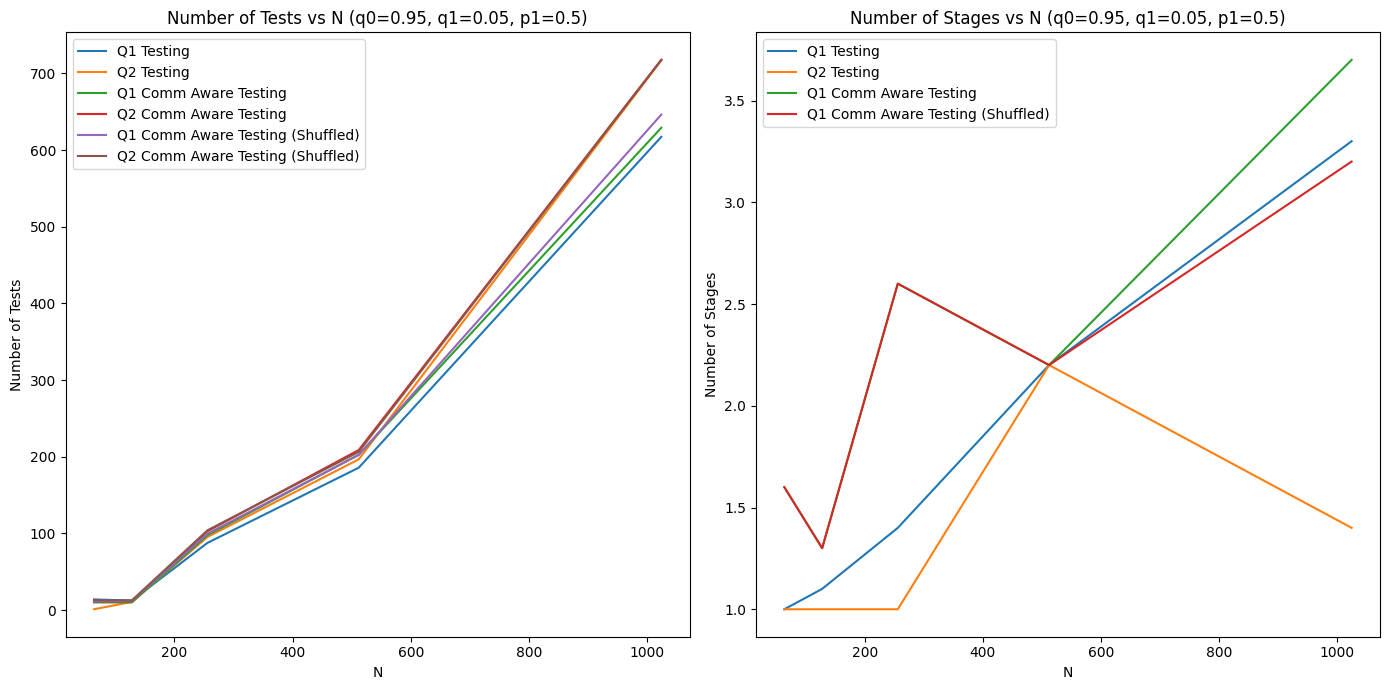

In [4]:
# Set parameters
p0 = 0.001
p1 = 0.5
q0 = 0.95
q1 = 0.05
N_values = [64, 128, 256, 512, 1024]
M_values = [8, 16, 32, 64, 128]

# Initialize lists to store results
results = {N: {"individual": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2": [], "Q2Comm": [],
               "Q1CommShuffled": [], "Q2CommShuffled": []} for N in N_values}

# Run simulations
num_simulations = 100
for N, M in zip(N_values, M_values):
    individual_tests_total, individual_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q2_tests_total, Q2_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
    Q2Comm_tests_total, Q2Comm_stages_total = 0, 0
    Q1CommShuffled_tests_total, Q1CommShuffled_stages_total = 0, 0
    Q2CommShuffled_tests_total, Q2CommShuffled_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        final_state = infect(G, p0, p1, 2)

        # Tests before shuffling
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
        Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
        
        # Shuffle and test again
        np.random.shuffle(final_state)
        individual_tests, individual_stages = individual_testing(final_state)
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q2_tests, Q2_stages = Qtesting2(final_state)
        Q1CommShuffled_tests, Q1CommShuffled_stages = Qtesting1_comm_aware(final_state, communities)
        Q2CommShuffled_tests, Q2CommShuffled_stages = Qtesting2_comm_aware(final_state, communities)

        individual_tests_total += individual_tests
        individual_stages_total += individual_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q2_tests_total += Q2_tests
        Q2_stages_total += Q2_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages
        Q2Comm_tests_total += Q2Comm_tests
        Q2Comm_stages_total += Q2Comm_stages
        Q1CommShuffled_tests_total += Q1CommShuffled_tests
        Q1CommShuffled_stages_total += Q1CommShuffled_stages
        Q2CommShuffled_tests_total += Q2CommShuffled_tests
        Q2CommShuffled_stages_total += Q2CommShuffled_stages

    results[N]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
    results[N]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
    results[N]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results[N]["Q2"].append((Q2_tests_total / num_simulations, Q2_stages_total / num_simulations))
    results[N]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
    results[N]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))
    results[N]["Q1CommShuffled"].append((Q1CommShuffled_tests_total / num_simulations, Q1CommShuffled_stages_total / num_simulations))
    results[N]["Q2CommShuffled"].append((Q2CommShuffled_tests_total / num_simulations, Q2CommShuffled_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 7))

tests_Q1 = [results[N]["Q1"][0][0] for N in N_values]
tests_Q2 = [results[N]["Q2"][0][0] for N in N_values]
tests_Q1Comm = [results[N]["Q1Comm"][0][0] for N in N_values]
tests_Q2Comm = [results[N]["Q2Comm"][0][0] for N in N_values]
tests_Q1CommShuffled = [results[N]["Q1CommShuffled"][0][0] for N in N_values]
tests_Q2CommShuffled = [results[N]["Q2CommShuffled"][0][0] for N in N_values]
tests_diag = [results[N]["diag"][0][0] for N in N_values]

stages_Q1 = [results[N]["Q1"][0][1] for N in N_values]
stages_Q2 = [results[N]["Q2"][0][1] for N in N_values]
stages_Q1Comm = [results[N]["Q1Comm"][0][1] for N in N_values]
stages_Q2Comm = [results[N]["Q2Comm"][0][1] for N in N_values]
stages_Q1CommShuffled = [results[N]["Q1CommShuffled"][0][1] for N in N_values]
stages_Q2CommShuffled = [results[N]["Q2CommShuffled"][0][1] for N in N_values]
stages_diag = [results[N]["diag"][0][1] for N in N_values]

plt.subplot(1, 2, 1)
plt.plot(N_values, tests_Q1, label='Q1 Testing')
plt.plot(N_values, tests_Q2, label='Q2 Testing')
plt.plot(N_values, tests_Q1Comm, label='Q1 Comm Aware Testing')
plt.plot(N_values, tests_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(N_values, tests_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
plt.plot(N_values, tests_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
# plt.plot(N_values, tests_diag, label='Diagonal Splitting')
plt.xlabel('N')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs N (q0={q0}, q1={q1}, p1={p1})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(N_values, stages_Q1, label='Q1 Testing')
plt.plot(N_values, stages_Q2, label='Q2 Testing')
plt.plot(N_values, stages_Q1Comm, label='Q1 Comm Aware Testing')
# plt.plot(N_values, stages_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(N_values, stages_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
# plt.plot(N_values, stages_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
# plt.plot(N_values, stages_diag, label='Diagonal Splitting')
plt.xlabel('N')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs N (q0={q0}, q1={q1}, p1={p1})')
plt.legend()

plt.tight_layout()
plt.show()


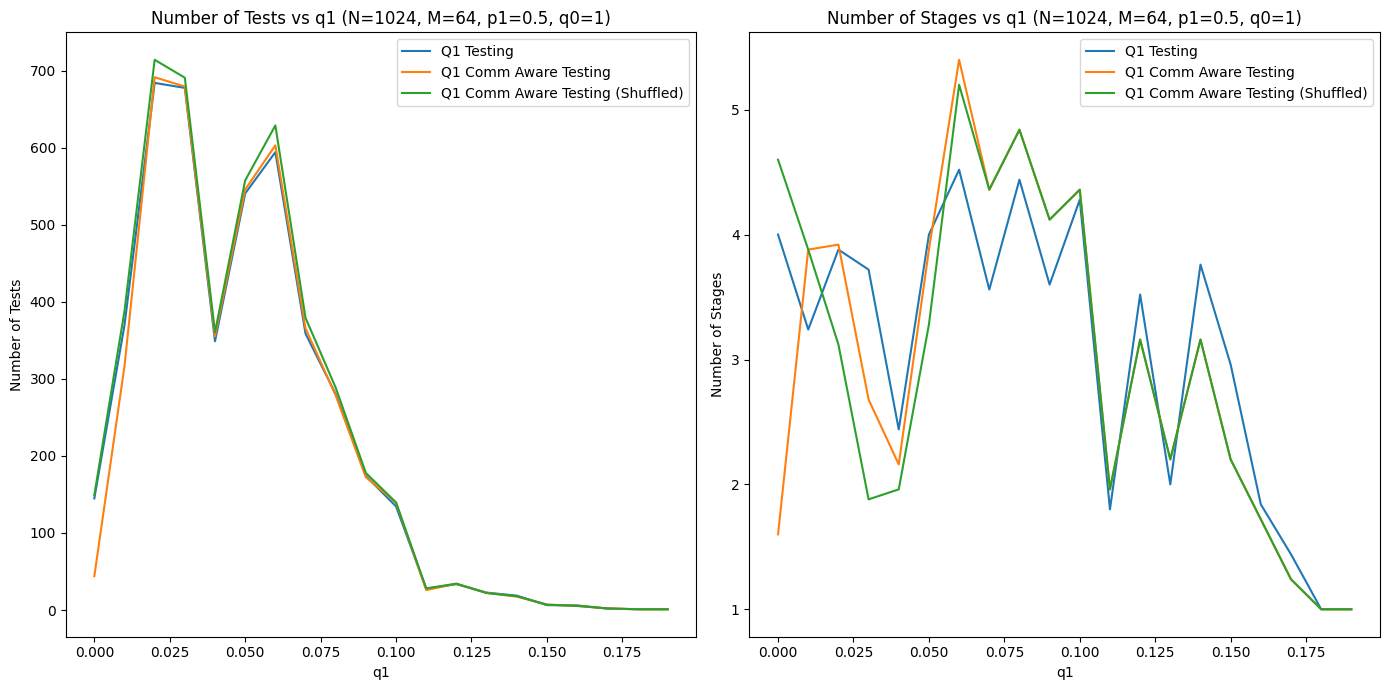

In [127]:
# q1 changing

# Set parameters
N = 1024
M = 64
q0 = 1
q1_values = np.arange(0, 0.2, 0.01)
p0 = 0.001
p1 = 0.5

# Initialize lists to store results
results = {q1: {"individual": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2": [], "Q2Comm": [],
               "Q1CommShuffled": [], "Q2CommShuffled": []} for q1 in q1_values}

# Run simulations
num_simulations = 100
for q1 in q1_values:
    individual_tests_total, individual_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q2_tests_total, Q2_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
    Q2Comm_tests_total, Q2Comm_stages_total = 0, 0
    Q1CommShuffled_tests_total, Q1CommShuffled_stages_total = 0, 0
    Q2CommShuffled_tests_total, Q2CommShuffled_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        final_state = infect(G, p0, p1, 2)

        # Tests before shuffling
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
        # Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)
        
        # Shuffle and test again
        np.random.shuffle(final_state)
        individual_tests, individual_stages = individual_testing(final_state)
        # diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        # Q2_tests, Q2_stages = Qtesting2(final_state)
        Q1CommShuffled_tests, Q1CommShuffled_stages = Qtesting1_comm_aware(final_state, communities)
        # Q2CommShuffled_tests, Q2CommShuffled_stages = Qtesting2_comm_aware(final_state, communities)

        individual_tests_total += individual_tests
        individual_stages_total += individual_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q2_tests_total += Q2_tests
        Q2_stages_total += Q2_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages
        Q2Comm_tests_total += Q2Comm_tests
        Q2Comm_stages_total += Q2Comm_stages
        Q1CommShuffled_tests_total += Q1CommShuffled_tests
        Q1CommShuffled_stages_total += Q1CommShuffled_stages
        Q2CommShuffled_tests_total += Q2CommShuffled_tests
        Q2CommShuffled_stages_total += Q2CommShuffled_stages

    results[q1]["individual"].append((individual_tests_total / num_simulations, individual_stages_total / num_simulations))
    results[q1]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
    results[q1]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results[q1]["Q2"].append((Q2_tests_total / num_simulations, Q2_stages_total / num_simulations))
    results[q1]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
    results[q1]["Q2Comm"].append((Q2Comm_tests_total / num_simulations, Q2Comm_stages_total / num_simulations))
    results[q1]["Q1CommShuffled"].append((Q1CommShuffled_tests_total / num_simulations, Q1CommShuffled_stages_total / num_simulations))
    results[q1]["Q2CommShuffled"].append((Q2CommShuffled_tests_total / num_simulations, Q2CommShuffled_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 7))

tests_Q1 = [results[q1]["Q1"][0][0] for q1 in q1_values]
tests_Q2 = [results[q1]["Q2"][0][0] for q1 in q1_values]
tests_Q1Comm = [results[q1]["Q1Comm"][0][0] for q1 in q1_values]
tests_Q2Comm = [results[q1]["Q2Comm"][0][0] for q1 in q1_values]
tests_Q1CommShuffled = [results[q1]["Q1CommShuffled"][0][0] for q1 in q1_values]
tests_Q2CommShuffled = [results[q1]["Q2CommShuffled"][0][0] for q1 in q1_values]
tests_diag = [results[q1]["diag"][0][0] for q1 in q1_values]

stages_Q1 = [results[q1]["Q1"][0][1] for q1 in q1_values]
stages_Q2 = [results[q1]["Q2"][0][1] for q1 in q1_values]
stages_Q1Comm = [results[q1]["Q1Comm"][0][1] for q1 in q1_values]
stages_Q2Comm = [results[q1]["Q2Comm"][0][1] for q1 in q1_values]
stages_Q1CommShuffled = [results[q1]["Q1CommShuffled"][0][1] for q1 in q1_values]
stages_Q2CommShuffled = [results[q1]["Q2CommShuffled"][0][1] for q1 in q1_values]
stages_diag = [results[q1]["diag"][0][1] for q1 in q1_values]

plt.subplot(1, 2, 1)
plt.plot(q1_values, tests_Q1, label='Q1 Testing')
# plt.plot(q1_values, tests_Q2, label='Q2 Testing')
plt.plot(q1_values, tests_Q1Comm, label='Q1 Comm Aware Testing')
# plt.plot(q1_values, tests_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(q1_values, tests_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
# plt.plot(q1_values, tests_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
# plt.plot(q1_values, tests_diag, label='Diagonal Splitting')
plt.xlabel('q1')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs q1 (N={N}, M={M}, p1={p1}, q0={q0})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(q1_values, stages_Q1, label='Q1 Testing')
# plt.plot(q1_values, stages_Q2, label='Q2 Testing')
plt.plot(q1_values, stages_Q1Comm, label='Q1 Comm Aware Testing')
# plt.plot(q1_values, stages_Q2Comm, label='Q2 Comm Aware Testing')
plt.plot(q1_values, stages_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
# plt.plot(q1_values, stages_Q2CommShuffled, label='Q2 Comm Aware Testing (Shuffled)')
# plt.plot(q1_values, stages_diag, label='Diagonal Splitting')
plt.xlabel('q1')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs q1 (N={N}, M={M}, p1={p1}, q0={q0})')
plt.legend()

plt.tight_layout()
plt.show()


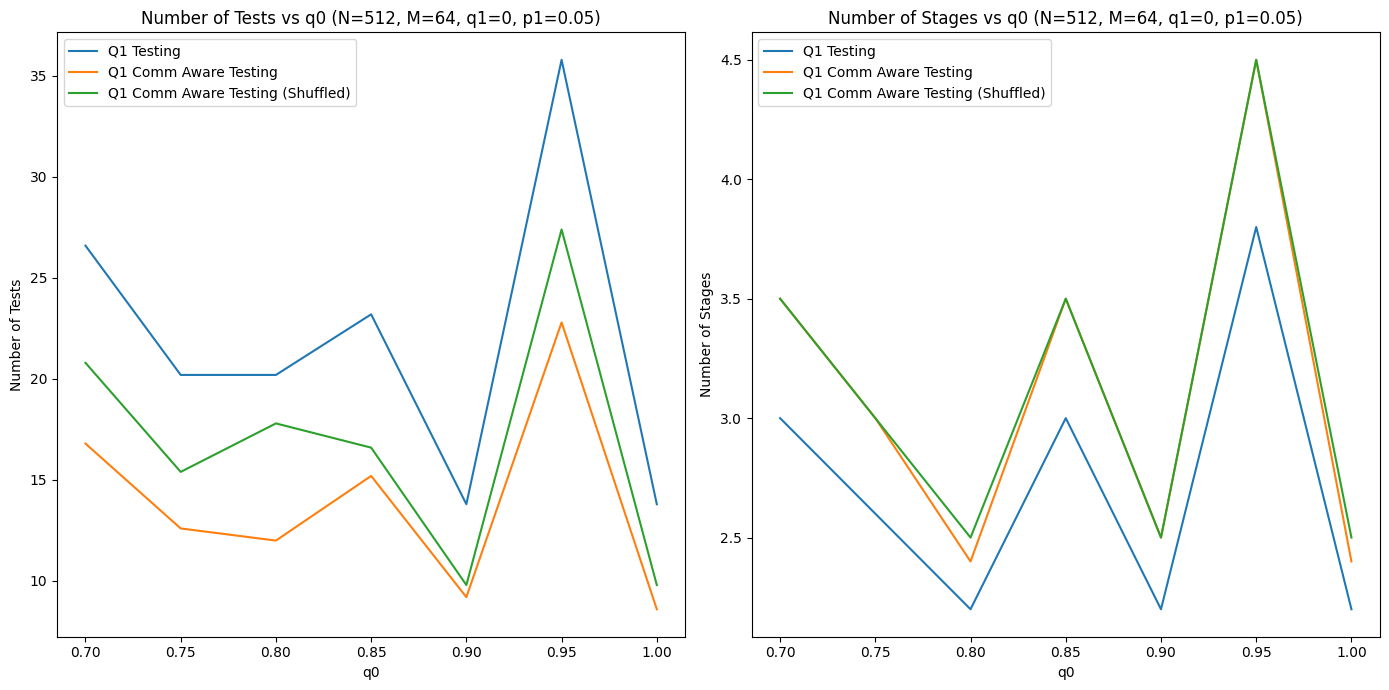

In [118]:


# Set parameters
N = 512
M = 64
q1 = 0
q0_values = np.arange(0.7, 1.01, 0.05)
p0 = 0.001
p1 = 0.05

# Initialize lists to store results
results = {q0: {"individual": [], "diag": [], "Q1": [], "Q1Comm": [], "Q2": [], "Q2Comm": [],
               "Q1CommShuffled": [], "Q2CommShuffled": []} for q0 in q0_values}

# Run simulations
num_simulations = 100
for q0 in q0_values:
    individual_tests_total, individual_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q2_tests_total, Q2_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0
    Q2Comm_tests_total, Q2Comm_stages_total = 0, 0
    Q1CommShuffled_tests_total, Q1CommShuffled_stages_total = 0, 0
    Q2CommShuffled_tests_total, Q2CommShuffled_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        final_state = infect(G, p0, p1, 2)

        # Tests before shuffling
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)
        
        # Shuffle and test again
        np.random.shuffle(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q1CommShuffled_tests, Q1CommShuffled_stages = Qtesting1_comm_aware(final_state, communities)

        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages
        Q1CommShuffled_tests_total += Q1CommShuffled_tests
        Q1CommShuffled_stages_total += Q1CommShuffled_stages

    results[q0]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results[q0]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))
    results[q0]["Q1CommShuffled"].append((Q1CommShuffled_tests_total / num_simulations, Q1CommShuffled_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 7))

tests_Q1 = [results[q0]["Q1"][0][0] for q0 in q0_values]
tests_Q1Comm = [results[q0]["Q1Comm"][0][0] for q0 in q0_values]
tests_Q1CommShuffled = [results[q0]["Q1CommShuffled"][0][0] for q0 in q0_values]

stages_Q1 = [results[q0]["Q1"][0][1] for q0 in q0_values]
stages_Q1Comm = [results[q0]["Q1Comm"][0][1] for q0 in q0_values]
stages_Q1CommShuffled = [results[q0]["Q1CommShuffled"][0][1] for q0 in q0_values]

plt.subplot(1, 2, 1)
plt.plot(q0_values, tests_Q1, label='Q1 Testing')
plt.plot(q0_values, tests_Q1Comm, label='Q1 Comm Aware Testing')
plt.plot(q0_values, tests_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
plt.xlabel('q0')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs q0 (N={N}, M={M}, q1={q1}, p1={p1})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(q0_values, stages_Q1, label='Q1 Testing')
plt.plot(q0_values, stages_Q1Comm, label='Q1 Comm Aware Testing')
plt.plot(q0_values, stages_Q1CommShuffled, label='Q1 Comm Aware Testing (Shuffled)')
plt.xlabel('q0')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs q0 (N={N}, M={M}, q1={q1}, p1={p1})')
plt.legend()

plt.tight_layout()
plt.show()

In [95]:
def iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm'):

    name = dataset+'N'+str(N)+'_M'+str(M)+'_SIM'+str(num_sims)+'_step'+str(time_steps)+'_q0'+str(q0)+'_q1'+str(q1)+'_p0'+str(p0)+'_p1'+str(p1)+method+'graphs.pkl'
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                ###################################################
                '''your code here'''
                # communities = []
                communities = create_communities(N,M)
                ###################################################
                Communities[i] = communities
                Individuals[i] = infect(Gs[i],p0,p1,time_steps)
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                # Individuals[i] = 
                # Communities[i] =[[all individuals]]
                Individuals[i] =  np.random.choice([0, 1], size=256, p=[1 - p0, p0])
                Communities[i] =[Individuals[i]]
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
    #         print('Dataset done!')


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = 0
    num_stages = 0
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        # print('Data loaded!')
    for i in range(num_sims):
        if dataset=='sbm':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
            
            #################################################
            fraction_ppl += sum(individuals)/len(individuals)

            num_infected_communities = 0
            infection_concentration = 0
            for community in communities:
                # print(sum(individuals[community]))
                if sum(individuals[community])>0:
                    num_infected_communities += 1
                    infection_concentration += sum(individuals[community])/len(community)

            fraction_family += num_infected_communities/len(communities)
            if num_infected_communities >0:
                fraction_ppl_in_family += infection_concentration/num_infected_communities
            else: fraction_ppl_in_family += 0


        ###################################################
        '''your code to calculate the statistics above^^^''' 

        
        ###################################################

        # interleave the individuals
        # s = individuals.copy()
        # np.random.shuffle(s)
        # # binary
        # numtests_bs, num_stages_bs, _ = binary_splitting(s)
        # # algorithm 1
        # numtests_q1, num_stages_q1 = Qtesting1(s)
        # # algorithm 2
        # numtests_q2, num_stages_q2 = Qtesting2(s)
        # # community-aware
        # numtests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(individuals.copy(),communities)
        # # community-aware
        # numtests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(individuals.copy(),communities)

    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''
    fraction_ppl = fraction_ppl/num_sims
    fraction_family = fraction_family/num_sims
    fraction_ppl_in_family = fraction_ppl_in_family/num_sims

    ###################################################
            

    return fraction_ppl, fraction_family, fraction_ppl_in_family, num_tests, num_stages

Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!


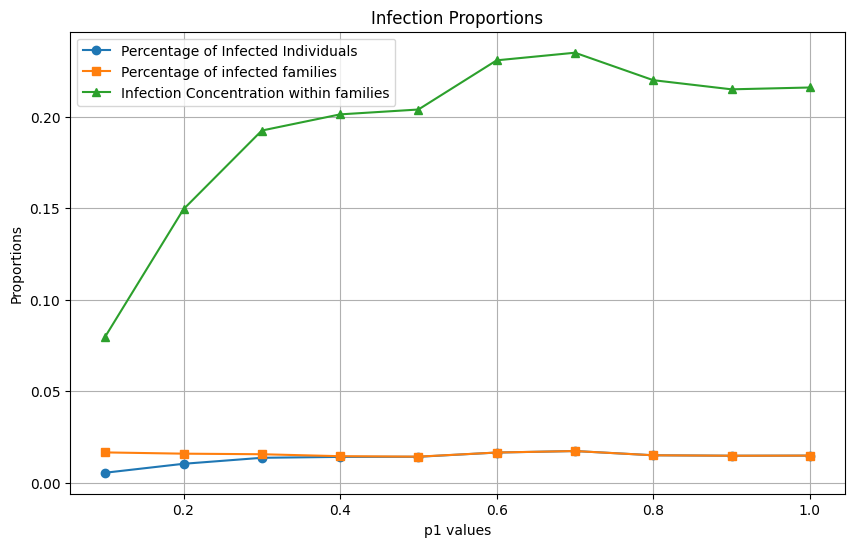

In [96]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 1
q1 = 0
time_steps = 2
p0 = 0.001
num_sims = 1000

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()



Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!
Generating synthetic dataset!


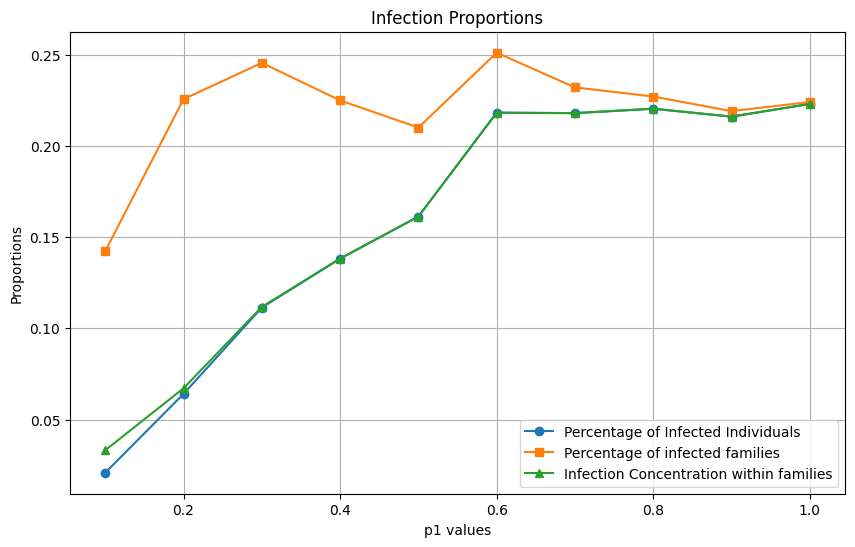

In [97]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 0.9
q1 = 0.1
time_steps = 2
p0 = 0.001
num_sims = 1000

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()

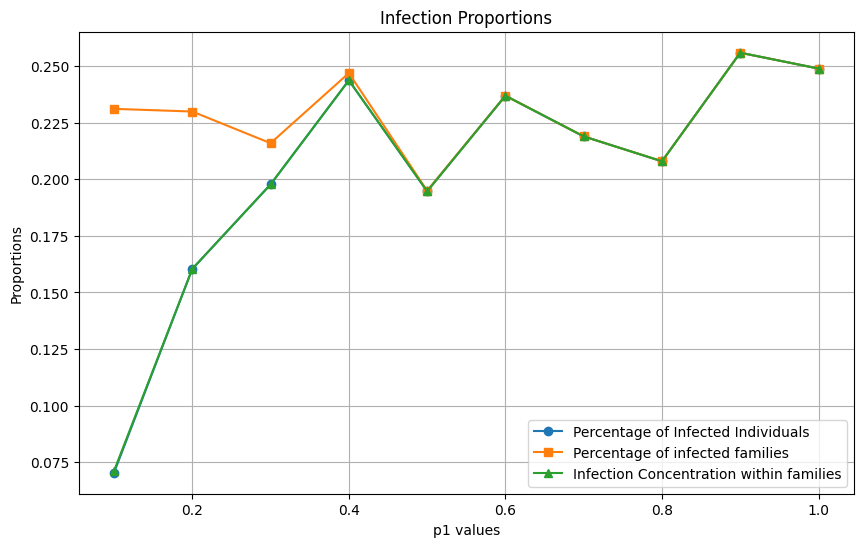

In [128]:
# Simulation and plotting 1
N = 256
M = 16
q0 = 0.5
q1 = 0.3
time_steps = 2
p0 = 0.001
num_sims = 1000

method = 'infection_rate'

t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
for j in range(1,t+1):
    p1 = j/t
    fraction_infected_ppl[j-1], fraction_infected_clc[j-1], fraction_infected_family[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  


x = np.linspace(0.1, 1, 10)
y1 = fraction_infected_ppl
y2 = fraction_infected_clc
y3 = fraction_infected_family

# Plotting the three arrays
plt.figure(figsize=(10, 6))

plt.plot(x, y1, label='Percentage of Infected Individuals', marker='o')
plt.plot(x, y2, label='Percentage of infected families', marker='s')
plt.plot(x, y3, label='Infection Concentration within families', marker='^')

plt.xlabel('p1 values')
plt.ylabel('Proportions')
plt.title('Infection Proportions')
plt.legend()
plt.grid(True)
plt.show()

